# Analyze GEval results

This notebook consists of analyzing results from GEval experiments obtained with the notebook `run_geval.ipynb` and stored in `resources`. Images and tables from this notebook were included in the thesis paper.

Before running this notebook, move it to the `geval` folder and make sure that:

1. There is a `comparison.csv` file, a `geval_embeddings` folder with the embeddings of DBpedia entities (produced in `run_geval.ipynb`), and the gold standards of each task in the `evaluation_framework` folder.

2. An `images` folder is created to store the images.

In [1]:
import pandas as pd
import scipy
from scipy.stats import binomtest
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


plt.style.use('ggplot')

In [2]:
df = pd.read_csv("comparison.csv", sep=",", decimal=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10390 entries, 0 to 10389
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   test_name            10390 non-null  object 
 1   task_name            10390 non-null  object 
 2   gold_standard_file   10390 non-null  object 
 3   coverage             10390 non-null  float64
 4   model                10390 non-null  object 
 5   model_configuration  10390 non-null  object 
 6   metric               10390 non-null  object 
 7   score_value          10390 non-null  float64
dtypes: float64(2), object(6)
memory usage: 649.5+ KB


In [3]:
df.describe()

,coverage,score_value
count,10390.000000,1.039000e+04
mean,0.947138,4.592387e+10
std,0.033151,1.382175e+12
min,0.838486,-5.716142e-02
25%,0.933962,5.399705e-02
50%,0.945141,4.955238e-01
75%,0.972366,6.480179e-01
max,1.000000,7.165813e+13


In [4]:
df.sort_values(by="coverage").head()

,test_name,task_name,gold_standard_file,coverage,model,model_configuration,metric,score_value
7991,geval_embeddings/geval-rdf2vec-cbow-oa-128-aut...,Classification,Forbes,0.838486,KNN,K=3,accuracy,0.527784
6997,geval_embeddings/geval-rdf2vec-cbow-oa-200-ori...,Classification,Forbes,0.838486,SVM,C=10.0,accuracy,0.556816
6996,geval_embeddings/geval-rdf2vec-cbow-oa-200-ori...,Classification,Forbes,0.838486,SVM,C=1.0,accuracy,0.590821
6995,geval_embeddings/geval-rdf2vec-cbow-oa-200-ori...,Classification,Forbes,0.838486,SVM,C=0.1,accuracy,0.577204
6994,geval_embeddings/geval-rdf2vec-cbow-oa-200-ori...,Classification,Forbes,0.838486,SVM,C=0.01,accuracy,0.483823


In [5]:
def shorten_test_name(test_name):
    test_name_short = test_name.split('_')[1]
    
    return test_name_short[17:]

def get_embedding_type(test_name_short):
    breakdown = test_name_short.split('-')
    
    embedding_type = '-'.join(breakdown[0:-2])
    
    if embedding_type.startswith("non-rdf2vec-"):
        return embedding_type.replace("non-rdf2vec-", "")
    
    else:
        return str.upper(embedding_type).replace("RDF2VEC-", "RDF2vec$_{") + "}$"

def get_embedding_variant(test_name_short):
    breakdown = test_name_short.split('-')
    
    return  breakdown[-1].replace("autoencoded", "auto") + "-" + breakdown[-2]

df['test_name_short'] = df['test_name'].apply(shorten_test_name)
df['embedding_type'] = df['test_name_short'].apply(get_embedding_type)
df['embedding_variant'] = df['test_name_short'].apply(get_embedding_variant)

print(df['embedding_type'].unique())
print(df['embedding_variant'].unique())

['RDF2vec$_{CBOW}$' 'RDF2vec$_{CBOW-OA}$' 'RDF2vec$_{SG-OA}$' 'ComplEx'
 'DistMult' 'RESCAL' 'RotatE' 'TransE-L1' 'TransE-L2' 'TransR'
 'RDF2vec$_{SG}$']
['original-200' 'avgbin-200' 'auto-128' 'auto-256' 'auto-512']


In [6]:
pd.pivot_table(
    df,
    values="coverage", 
    index=["gold_standard_file"],
    columns=["embedding_type"],
    aggfunc='mean',
)

embedding_type,ComplEx,DistMult,RDF2vec$_{CBOW-OA}$,RDF2vec$_{CBOW}$,RDF2vec$_{SG-OA}$,RDF2vec$_{SG}$,RESCAL,RotatE,TransE-L1,TransE-L2,TransR
gold_standard_file,,,,,,,,,,,
AAUP,0.985417,0.985417,0.982292,0.982292,0.982292,0.982292,0.985417,0.985417,0.985417,0.985417,0.985417
Cities,0.981132,0.981132,0.933962,0.981132,0.933962,0.981132,0.981132,0.981132,0.981132,0.981132,0.981132
Forbes,0.856151,0.856151,0.838486,0.844795,0.838486,0.844795,0.856151,0.856151,0.856151,0.856151,0.856151
KORE,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
LP50,0.945141,0.945141,0.940439,0.940439,0.940439,0.940439,0.945141,0.945141,0.945141,0.945141,0.945141
MetacriticAlbums,0.948125,0.948125,0.943125,0.943750,0.943125,0.943750,0.948125,0.948125,0.948125,0.948125,0.948125
MetacriticMovies,0.934500,0.934500,0.933500,0.934000,0.933500,0.934000,0.934500,0.934500,0.934500,0.934500,0.934500
all_capital_country_entities,0.982759,0.982759,0.982759,0.982759,0.982759,0.982759,0.982759,0.982759,0.982759,0.982759,0.982759
capital_country_entities,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
pd.pivot_table(
    df,
    values="coverage", 
    index=["gold_standard_file"],
    columns=["embedding_type"],
    aggfunc='std',
)

embedding_type,ComplEx,DistMult,RDF2vec$_{CBOW-OA}$,RDF2vec$_{CBOW}$,RDF2vec$_{SG-OA}$,RDF2vec$_{SG}$,RESCAL,RotatE,TransE-L1,TransE-L2,TransR
gold_standard_file,,,,,,,,,,,
AAUP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Forbes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KORE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LP50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MetacriticAlbums,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MetacriticMovies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
all_capital_country_entities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
capital_country_entities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df['gold_standard_file'] = df['gold_standard_file'].str.replace("_", "-")

dataset_lengths = { 
    "AAUP": 933,
    "Cities": 212,
    "Forbes": 1585,
    "MetacriticAlbums": 1592,
    "MetacriticMovies": 2000,
    "cities2000AndCountries-cluster": 4343,
    "citiesAndCountries-cluster": 11179,
    "citiesMoviesAlbumsCompaniesUni-cluster": 6322,
    "teams-cluster": 4206,
    "currency-entities": 58, 
    "city-state-entities": 94,
    "capital-country-entities": 46, 
    "all-capital-country-entities": 232,
}

In [9]:
emb_types_ordered = [    
    'RDF2vec$_{CBOW}$',
    'RDF2vec$_{CBOW-OA}$', 
    'RDF2vec$_{SG}$', 
    'RDF2vec$_{SG-OA}$', 
    
    'RESCAL',
    'DistMult',
    'ComplEx',
     
    'TransE-L1',
    'TransE-L2',
    'TransR',
    'RotatE',
]

## Classification

In [10]:
df_clf = df[
    (df['task_name']=='Classification') 
    & (df['metric']=='accuracy')
    & (df['coverage']>=0)
].drop(columns=['test_name'])
df_clf['rank'] = df_clf.groupby(by=['test_name_short', 'gold_standard_file'])['score_value'].rank(
    method='first', 
    ascending=False,
)
df_clf_bestscores = df_clf[df_clf['rank']==1.0].drop(columns=['rank', 'task_name']).sort_values(
    by=['gold_standard_file', 'score_value'], ascending=False
)

df_clf_bestscores['gold_standard_file'].unique()

array(['MetacriticMovies', 'MetacriticAlbums', 'Forbes', 'Cities', 'AAUP'],
      dtype=object)

In [11]:
def get_acc_loss(gold_standard_file, score_value, embedding_type):
    p = df_clf_bestscores[
        (df_clf_bestscores["gold_standard_file"]==gold_standard_file)
        & (df_clf_bestscores["embedding_type"]==embedding_type)
        & (df_clf_bestscores["embedding_variant"]=="original-200")
    ]["score_value"].iloc[0]

    return (p - score_value)/p


def calculate_pvalue_clf(gold_standard_file, score_value, embedding_type):
    n = dataset_lengths.get(gold_standard_file)
    successes = round(n*score_value)
    p = df_clf_bestscores[
        (df_clf_bestscores["gold_standard_file"]==gold_standard_file)
        & (df_clf_bestscores["embedding_type"]==embedding_type)
        & (df_clf_bestscores["embedding_variant"]=="original-200")
    ]["score_value"].iloc[0]

    return binomtest(successes, n, p, alternative='less').pvalue
    
df_clf_bestscores["acc_loss"] = df_clf_bestscores.apply(
    lambda x: get_acc_loss(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)
    
df_clf_bestscores["pvalue_worse_than_original"] = df_clf_bestscores.apply(
    lambda x: calculate_pvalue_clf(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)

alpha=0.05
df_clf_bestscores["not_worse_than_original"] = df_clf_bestscores["pvalue_worse_than_original"] >= alpha

df_clf_bestscores[["pvalue_worse_than_original", "acc_loss"]].describe()

,pvalue_worse_than_original,acc_loss
count,2.200000e+02,220.000000
mean,1.109628e-01,0.051632
std,1.879894e-01,0.038209
min,3.793150e-14,-0.027468
25%,1.196703e-03,0.027240
50%,2.054028e-02,0.047956
75%,1.224953e-01,0.071941
max,8.645604e-01,0.230881


In [12]:
def reorganize_latex_table(latex_table):
    latex_table_split = latex_table.split("\n")
    
    latex_table_split[0] += "[h!]"
    caption = latex_table_split.pop(2)
    label = latex_table_split.pop(2)
    end_string = latex_table_split.pop(-1)
    end_table = latex_table_split.pop(-1)

    latex_table_split.extend([caption, label, end_table, end_string])
    return "\n".join(latex_table_split)


def highlight_best_scores(latex_table, max_value=True):
    latex_table_split = latex_table.split("\n")
    highlighted_latex_table_split = []

    for line in latex_table_split:
        line_split = line.strip("\\").split("&")
        if len(line_split) >= 4:
            line_values = []
            for value in line_split:
                if value.strip().replace(".", "").isnumeric():
                    line_values.append(float(value.strip())) 
            if len(line_values) >= 4:
                line_max_value = max(line_values) if max_value else min(line_values)
                line_formatted = []
                for value in line_split: 
                    value_numeric = float(value.strip()) if value.strip().replace(".", "").isnumeric() else 0.0
                    new_value = "\t\\textbf{" + value.strip() + "}" if value_numeric==line_max_value else value
                    line_formatted.append(new_value)
                if len(line_formatted)>0:
                    highlighted_latex_table_split.append(" &".join(line_formatted) + " \\" + "\\")
            else:
                highlighted_latex_table_split.append(line)
        else:
                highlighted_latex_table_split.append(line)
    return "\n".join(highlighted_latex_table_split)


In [13]:
caption="Count of GEval classification datasets in which the best classifier " + \
    "of each binary embedding variant did not significantly underperfom the original one in accuracy. " + \
    "The closer to 5, the less is the performance loss. $\\alpha=0.05$."

df_clf_sig_not_worst = pd.pivot_table(
    df_clf_bestscores[df_clf_bestscores["embedding_variant"]!="original-200"],
    values="not_worse_than_original", 
    index=["embedding_type"],
    columns=["embedding_variant"],
    aggfunc=lambda x: sum(x),
).loc[emb_types_ordered,:]

print(caption) 
print(r"in table \ref{tab:geval-clf-acc-significantly-not-worse}.")

print(highlight_best_scores(reorganize_latex_table(df_clf_sig_not_worst.to_latex(
    escape=False,
    index_names=False,
    label="tab:geval-clf-acc-significantly-not-worse",
    caption=caption,
    columns=[
        "avgbin-200",
        "auto-128",
        "auto-256",
        "auto-512",
    ]
))))

print(df_clf_sig_not_worst.mean())

print(df_clf_sig_not_worst.mean(axis=1))

df_clf_sig_not_worst

Count of GEval classification datasets in which the best classifier of each binary embedding variant did not significantly underperfom the original one in accuracy. The closer to 5, the less is the performance loss. $\alpha=0.05$.
in table \ref{tab:geval-clf-acc-significantly-not-worse}.
\begin{table}[h!]
\centering
\begin{tabular}{lrrrr}
\toprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{4} &         3  &	\textbf{4} &         2  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{3} &         1  &         1  &	\textbf{3} \\
RDF2vec$_{SG}$       &           3  &         3  &         3  &	\textbf{5} \\
RDF2vec$_{SG-OA}$    &           1  &         3  &         3  &	\textbf{4} \\
RESCAL               &	\textbf{2} &         1  &	\textbf{2} &	\textbf{2} \\
DistMult             &	\textbf{1} &         0  &	\textbf{1} &	\textbf{1} \\
ComplEx              &           0  &	\textbf{1} &         0  &         0  \\
TransE-L1            &           2  &         1

embedding_variant,auto-128,auto-256,auto-512,avgbin-200
embedding_type,,,,
RDF2vec$_{CBOW}$,3,4,2,4
RDF2vec$_{CBOW-OA}$,1,1,3,3
RDF2vec$_{SG}$,3,3,5,3
RDF2vec$_{SG-OA}$,3,3,4,1
RESCAL,1,2,2,2
DistMult,0,1,1,1
ComplEx,1,0,0,0
TransE-L1,1,2,3,2
TransE-L2,3,2,2,1


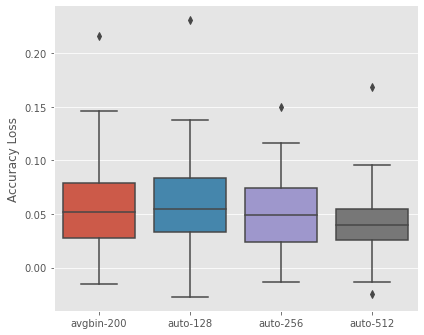

GEval classification accuracy loss by binarization technique in Figure \ref{fig:geval-clf-acc-loss}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-clf-acc-loss.png}}
    \caption{GEval Classification Accuracy Loss by Binarization Technique}
    \label{fig:geval-clf-acc-loss}
\end{figure}


In [14]:
g = sns.catplot(
    data=df_clf_bestscores[df_clf_bestscores["embedding_variant"]!="original-200"], 
    x="embedding_variant", 
    y="acc_loss",
    kind="box",
    aspect=1.2,
    order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "Accuracy Loss")
# g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle('GEval Classification Accuracy Loss by Binarization Technique')

plt.savefig("images/geval-clf-acc-loss.png")

plt.show()
    
print("GEval classification accuracy loss by binarization technique in Figure \\ref{fig:geval-clf-acc-loss}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-clf-acc-loss.png}}")
print("    \caption{GEval Classification Accuracy Loss by Binarization Technique}")
print("    \label{fig:geval-clf-acc-loss}")
print("\end{figure}")

In [15]:
def get_latex_table_clf_acc(gold_standard_file):
    gold_standard_file_lower = str.lower(gold_standard_file).replace("_", "-")
    
    pivot_table = pd.pivot_table(
        df_clf_bestscores[df_clf_bestscores["gold_standard_file"]==gold_standard_file], 
        values="score_value", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    )
    emb_types_ordered_in_pt = [x for x in emb_types_ordered if x in pivot_table.index]
    latex_table = pivot_table.loc[emb_types_ordered_in_pt,:].to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:geval-clf-acc-{gold_standard_file_lower}",
        caption=f"Accuracy scores for best classifier of each embedding variant in dataset {gold_standard_file}",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )
    return highlight_best_scores(reorganize_latex_table(latex_table))

\subsubsection{MetacriticMovies Dataset}
\label{subsubsec:geval-results-clf-metacriticmovies} 

GEval Classification Accuracy Loss for MetacriticMovies Dataset in Figure \ref{fig:geval-clf-acc-loss-metacriticmovies}.

\begin{figure}[h!]
    \centering
    \includegraphics[width=0.85\linewidth]{assets/geval-clf-acc-loss-metacriticmovies.png}
    \caption{GEval Classification Accuracy Loss for MetacriticMovies Dataset}
    \label{fig:geval-clf-acc-loss-metacriticmovies}
\end{figure}



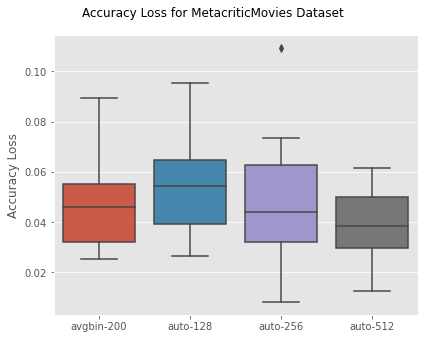

Accuracy scores for MetacriticMovies Dataset in table \ref{tab:geval-clf-acc-metacriticmovies}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.538} &       0.523  &     0.523  &     0.533  &     0.507  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.620} &       0.604  &     0.580  &     0.581  &     0.597  \\
RDF2vec$_{SG}$       &	\textbf{0.714} &       0.688  &     0.686  &     0.695  &     0.705  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.712} &       0.677  &     0.684  &     0.690  &     0.680  \\
RESCAL               &	\textbf{0.683} &       0.664  &     0.663  &     0.658  &     0.662  \\
DistMult             &	\textbf{0.673} &       0.613  &     0.637  &     0.644  &     0.654  \\
ComplEx              &	\textbf{0.695} &       0.646  &     0.658  &     0.658  &     0.666  \\
TransE-L1            &	\textbf{0.640} &       0.610  &     0.579  &     0.570  &     0.602  \\

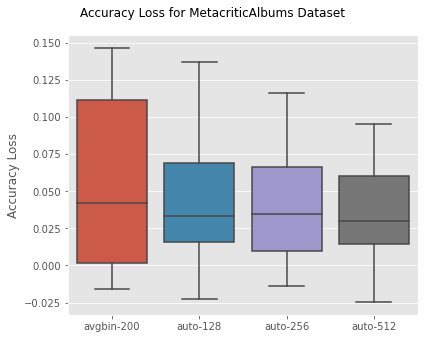

Accuracy scores for MetacriticAlbums Dataset in table \ref{tab:geval-clf-acc-metacriticalbums}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &         0.530  &       0.539  &     0.529  &     0.538  &	\textbf{0.543} \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.519} &	\textbf{0.519} &     0.506  &     0.511  &     0.507  \\
RDF2vec$_{SG}$       &         0.582  &       0.584  &	\textbf{0.595} &     0.581  &     0.583  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.581} &       0.580  &     0.576  &     0.579  &     0.578  \\
RESCAL               &	\textbf{0.620} &       0.561  &     0.572  &     0.567  &     0.577  \\
DistMult             &	\textbf{0.630} &       0.538  &     0.568  &     0.578  &     0.597  \\
ComplEx              &	\textbf{0.628} &       0.548  &     0.614  &     0.597  &     0.599  \\
TransE-L1            &	\textbf{0.622} &       0.596  &     0.585  &     0.603  &    

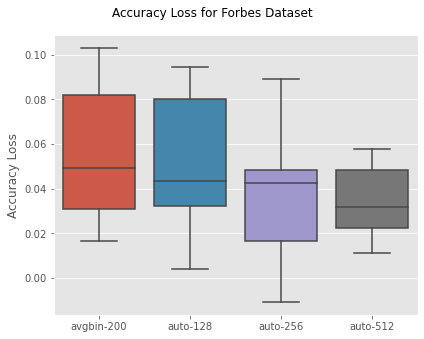

Accuracy scores for Forbes Dataset in table \ref{tab:geval-clf-acc-forbes}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.565} &       0.551  &     0.546  &     0.560  &     0.559  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.591} &       0.555  &     0.565  &     0.565  &     0.572  \\
RDF2vec$_{SG}$       &	\textbf{0.612} &       0.596  &     0.609  &     0.607  &     0.605  \\
RDF2vec$_{SG-OA}$    &         0.595  &       0.570  &     0.581  &	\textbf{0.602} &     0.583  \\
RESCAL               &	\textbf{0.594} &       0.546  &     0.538  &     0.545  &     0.565  \\
DistMult             &	\textbf{0.562} &       0.509  &     0.514  &     0.548  &     0.532  \\
ComplEx              &	\textbf{0.569} &       0.541  &     0.525  &     0.545  &     0.536  \\
TransE-L1            &	\textbf{0.565} &       0.545  &     0.543  &     0.552  &     0.540  \\
TransE-L2      

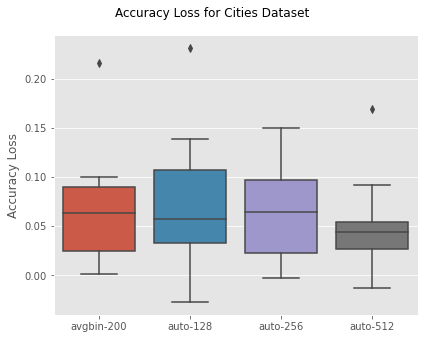

Accuracy scores for Cities Dataset in table \ref{tab:geval-clf-acc-cities}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.703} &       0.686  &     0.630  &     0.657  &     0.639  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.716} &       0.678  &     0.653  &     0.637  &     0.683  \\
RDF2vec$_{SG}$       &         0.783  &       0.782  &     0.763  &     0.765  &	\textbf{0.793} \\
RDF2vec$_{SG-OA}$    &	\textbf{0.785} &       0.717  &     0.754  &     0.769  &     0.763  \\
RESCAL               &         0.745  &       0.732  &	\textbf{0.763} &     0.747  &     0.751  \\
DistMult             &	\textbf{0.672} &       0.629  &     0.579  &     0.600  &     0.631  \\
ComplEx              &	\textbf{0.735} &       0.577  &     0.565  &     0.625  &     0.611  \\
TransE-L1            &	\textbf{0.679} &       0.611  &     0.640  &     0.622  &     0.660  \\
TransE-L2  

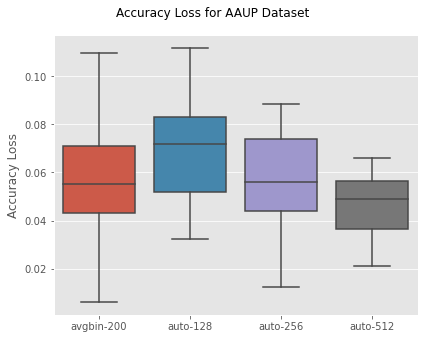

Accuracy scores for AAUP Dataset in table \ref{tab:geval-clf-acc-aaup}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.630} &       0.597  &     0.560  &     0.574  &     0.588  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.688} &       0.638  &     0.630  &     0.632  &     0.648  \\
RDF2vec$_{SG}$       &	\textbf{0.696} &       0.670  &     0.663  &     0.661  &     0.677  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.705} &       0.666  &     0.656  &     0.679  &     0.681  \\
RESCAL               &	\textbf{0.643} &       0.639  &     0.607  &     0.635  &     0.619  \\
DistMult             &	\textbf{0.628} &       0.559  &     0.572  &     0.584  &     0.594  \\
ComplEx              &	\textbf{0.614} &       0.571  &     0.563  &     0.568  &     0.582  \\
TransE-L1            &	\textbf{0.630} &       0.609  &     0.602  &     0.594  &     0.616  \\
TransE-L2            &	

In [16]:
for gold_standard_file in df_clf_bestscores['gold_standard_file'].unique():
    dataset_lower = str.lower(gold_standard_file).replace("_", "-")
    print("\subsubsection{"+gold_standard_file+" Dataset}")
    print("\label{subsubsec:geval-results-clf-"+dataset_lower+"} \n")

    g = sns.catplot(
        data=df_clf_bestscores[
            (df_clf_bestscores["embedding_variant"]!="original-200")
            & (df_clf_bestscores["gold_standard_file"]==gold_standard_file)
        ], 
        x="embedding_variant", 
        y="acc_loss",
        kind="box",
        aspect=1.2,
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
    )

    g.set_axis_labels("", "Accuracy Loss")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Accuracy Loss for {gold_standard_file} Dataset')

    plt.savefig(f"images/geval-clf-acc-loss-{dataset_lower}.png")

    print("GEval Classification Accuracy Loss for "+gold_standard_file+" Dataset in Figure \\ref{fig:geval-clf-acc-loss-"+dataset_lower+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \includegraphics[width=0.85\\linewidth]{assets/geval-clf-acc-loss-"+dataset_lower+".png}")
    print("    \caption{GEval Classification Accuracy Loss for "+gold_standard_file+" Dataset}")
    print("    \label{fig:geval-clf-acc-loss-"+dataset_lower+"}")
    print("\end{figure}\n")

    plt.show()

    print("Accuracy scores for "+gold_standard_file+" Dataset in table \\ref{tab:geval-clf-acc-"+dataset_lower+"}.\n\n")


    print(get_latex_table_clf_acc(gold_standard_file))



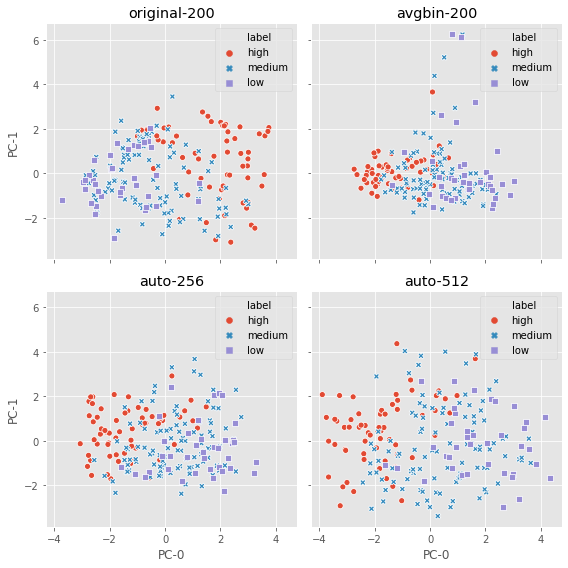

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=0.95\linewidth]{assets/geval-clf-cities-scatter.png}}
    \caption{Class separation of RDF2vec_SG variants in dataset Cities, visualized in 2 dimensions using PCA.}
    \label{fig:geval-clf-cities-scatter}
\end{figure}


In [17]:
gold_standard_path = "evaluation_framework/Classification/data/Cities.tsv"
plot_vector_files = [
    ("original-200", "geval_embeddings/geval-rdf2vec-sg-200-original.txt", 0, 0),
    ("avgbin-200", "geval_embeddings/geval-rdf2vec-sg-200-avgbin.txt", 0, 1),
#     ("auto-128", "geval_embeddings/geval-rdf2vec-sg-128-autoencoded.txt", 1, 0),
    ("auto-256", "geval_embeddings/geval-rdf2vec-sg-256-autoencoded.txt", 1, 0),
    ("auto-512", "geval_embeddings/geval-rdf2vec-sg-512-autoencoded.txt", 1, 1),
]

gold_standard_df = pd.read_csv(gold_standard_path, sep='\t')[['DBpedia_URI', 'label']]

fig, axs = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(8, 8),
    sharex=True,
    sharey=True,
)

for embedding_txt_file_tuple in plot_vector_files:
    title, embedding_txt_file, row, col = embedding_txt_file_tuple
    emb = pd.read_csv(
        embedding_txt_file, sep=' ', header=None
    ).rename(
        columns={0:'DBpedia_URI'}
    )
    emb.pop(emb.columns[-1])
    emb = emb[emb['DBpedia_URI'].isin(gold_standard_df['DBpedia_URI'])]
    emb_df = pd.merge(gold_standard_df, emb, how='inner', on='DBpedia_URI')
    pca = PCA(n_components=2)
    emb_pca = pca.fit_transform(emb_df.iloc[: , 2:])
    emb_df['PC-0'] = emb_pca.T[0]
    emb_df['PC-1'] = emb_pca.T[1]

    sns.scatterplot(
        data=emb_df,
        x='PC-0',
        y='PC-1',
        hue='label',
        style='label',
        ax=axs[row, col],
    ).set(title=title)
plt.tight_layout()

plt.savefig("images/geval-clf-cities-scatter.png")

plt.show()
    
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=0.95\linewidth]{assets/geval-clf-cities-scatter.png}}")
print("    \caption{Class separation of RDF2vec_SG variants in dataset Cities, visualized in 2 dimensions using PCA.}")
print("    \label{fig:geval-clf-cities-scatter}")
print("\end{figure}")

## Clustering

In [18]:
df_clt = df[
    (df['task_name']=='Clustering') 
    & (df['metric']=='clustering_accuracy')
    & (df['coverage']>=0)
].drop(columns=['test_name'])
df_clt['rank'] = df_clt.groupby(by=['test_name_short', 'gold_standard_file'])['score_value'].rank(
    method='first', 
    ascending=False,
)
df_clt_bestscores = df_clt[df_clt['rank']==1.0].drop(columns=['rank', 'task_name']).sort_values(
    by=['gold_standard_file', 'score_value'], ascending=False
)

df_clt_bestscores['gold_standard_file'].unique()

array(['teams-cluster', 'citiesMoviesAlbumsCompaniesUni-cluster',
       'citiesAndCountries-cluster', 'cities2000AndCountries-cluster'],
      dtype=object)

In [19]:
def get_acc_loss(gold_standard_file, score_value, embedding_type):
    p = df_clt_bestscores[
        (df_clt_bestscores["gold_standard_file"]==gold_standard_file)
        & (df_clt_bestscores["embedding_type"]==embedding_type)
        & (df_clt_bestscores["embedding_variant"]=="original-200")
    ]["score_value"].iloc[0]

    return (p - score_value)/p


def calculate_pvalue_clt(gold_standard_file, score_value, embedding_type):
    n = dataset_lengths.get(gold_standard_file)
    successes = round(n*score_value)
    p = df_clt_bestscores[
        (df_clt_bestscores["gold_standard_file"]==gold_standard_file)
        & (df_clt_bestscores["embedding_type"]==embedding_type)
        & (df_clt_bestscores["embedding_variant"]=="original-200")
    ]["score_value"].iloc[0]

    return binomtest(successes, n, p, alternative='less').pvalue
    
df_clt_bestscores["acc_loss"] = df_clt_bestscores.apply(
    lambda x: get_acc_loss(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)
    
df_clt_bestscores["pvalue_worse_than_original"] = df_clt_bestscores.apply(
    lambda x: calculate_pvalue_clt(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)

alpha=0.05
df_clt_bestscores["not_worse_than_original"] = df_clt_bestscores["pvalue_worse_than_original"] >= alpha

df_clt_bestscores[["pvalue_worse_than_original", "acc_loss"]].describe()

,pvalue_worse_than_original,acc_loss
count,1.760000e+02,176.000000
mean,3.487939e-01,-0.002136
std,3.958265e-01,0.125977
min,0.000000e+00,-0.770153
25%,1.859448e-09,0.000000
50%,1.172841e-01,0.004899
75%,5.092960e-01,0.026900
max,1.000000e+00,0.352095


In [20]:
caption="Count of GEval clustering datasets in which the best clusterer of each binary " + \
    "embedding variant did not significantly underperfom the original one in clustering accuracy. " + \
    "The closer to 4, the less is the performance loss. $\\alpha=0.05$."

df_clt_sig_not_worst = pd.pivot_table(
    df_clt_bestscores[df_clt_bestscores["embedding_variant"]!="original-200"],
    values="not_worse_than_original", 
    index=["embedding_type"],
    columns=["embedding_variant"],
    aggfunc=lambda x: sum(x),
).loc[emb_types_ordered,:]

print(caption)
print(r"in table \ref{tab:geval-clt-acc-significantly-not-worse}.")

print(highlight_best_scores(reorganize_latex_table(df_clt_sig_not_worst.to_latex(
    escape=False,
    index_names=False,
    label="tab:geval-clt-acc-significantly-not-worse",
    caption=caption,
    columns=[
        "avgbin-200",
        "auto-128",
        "auto-256",
        "auto-512",
    ]
))))

print(df_clt_sig_not_worst.mean())

print(df_clt_sig_not_worst.mean(axis=1))

df_clt_sig_not_worst

Count of GEval clustering datasets in which the best clusterer of each binary embedding variant did not significantly underperfom the original one in clustering accuracy. The closer to 4, the less is the performance loss. $\alpha=0.05$.
in table \ref{tab:geval-clt-acc-significantly-not-worse}.
\begin{table}[h!]
\centering
\begin{tabular}{lrrrr}
\toprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{2} &	\textbf{2} &	\textbf{2} &	\textbf{2} \\
RDF2vec$_{CBOW-OA}$  &	\textbf{4} &	\textbf{4} &	\textbf{4} &	\textbf{4} \\
RDF2vec$_{SG}$       &           3  &	\textbf{4} &	\textbf{4} &	\textbf{4} \\
RDF2vec$_{SG-OA}$    &           2  &         2  &	\textbf{3} &	\textbf{3} \\
RESCAL               &	\textbf{1} &         0  &         0  &	\textbf{1} \\
DistMult             &           1  &         2  &         2  &	\textbf{3} \\
ComplEx              &	\textbf{2} &         1  &	\textbf{2} &         1  \\
TransE-L1            &	\textbf{2} &	\text

embedding_variant,auto-128,auto-256,auto-512,avgbin-200
embedding_type,,,,
RDF2vec$_{CBOW}$,2,2,2,2
RDF2vec$_{CBOW-OA}$,4,4,4,4
RDF2vec$_{SG}$,4,4,4,3
RDF2vec$_{SG-OA}$,2,3,3,2
RESCAL,0,0,1,1
DistMult,2,2,3,1
ComplEx,1,2,1,2
TransE-L1,2,2,2,2
TransE-L2,2,2,2,3


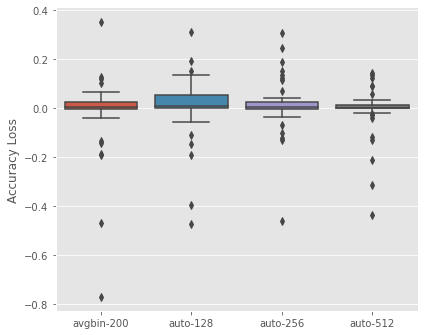

Clustering accuracy loss by binarization technique in Figure \ref{fig:geval-clt-acc-loss}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-clt-acc-loss.png}}
    \caption{GEval Clustering Accuracy Loss by Binarization Technique}
    \label{fig:geval-clt-acc-loss}
\end{figure}


In [21]:
g = sns.catplot(
    data=df_clt_bestscores[df_clt_bestscores["embedding_variant"]!="original-200"], 
    x="embedding_variant", 
    y="acc_loss",
    kind="box",
    aspect=1.2,
    order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "Accuracy Loss")
# g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle('Clustering Accuracy Loss by Binarization Technique')

plt.savefig("images/geval-clt-acc-loss.png")

plt.show()
    
print("Clustering accuracy loss by binarization technique in Figure \\ref{fig:geval-clt-acc-loss}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-clt-acc-loss.png}}")
print("    \caption{GEval Clustering Accuracy Loss by Binarization Technique}")
print("    \label{fig:geval-clt-acc-loss}")
print("\end{figure}")

In [22]:
def get_latex_table_clt_acc(gold_standard_file):
    gold_standard_file_lower = str.lower(gold_standard_file).replace("_", "-")
    
    pivot_table = pd.pivot_table(
        df_clt_bestscores[df_clt_bestscores["gold_standard_file"]==gold_standard_file], 
        values="score_value", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    )
    
    emb_types_ordered_in_pt = [x for x in emb_types_ordered if x in pivot_table.index]
    latex_table = pivot_table.loc[emb_types_ordered_in_pt,:].to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:geval-clt-acc-{gold_standard_file_lower}",
        caption=f"Clustering accuracy scores for best clusterer of each embedding variant in dataset {gold_standard_file}",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )
    
    return highlight_best_scores(reorganize_latex_table(latex_table))

\subsubsection{teams-cluster Dataset}
\label{subsubsec:geval-results-clt-teams-cluster} 

GEval Clustering Accuracy Loss for teams-cluster Dataset in Figure \ref{fig:geval-clt-acc-loss-teams-cluster}.

\begin{figure}[h!]
    \centering
    \includegraphics[width=0.85\linewidth]{assets/geval-clt-acc-loss-teams-cluster.png}
    \caption{GEval Clustering Accuracy Loss for teams-cluster Dataset}
    \label{fig:geval-clt-acc-loss-teams-cluster}
\end{figure}



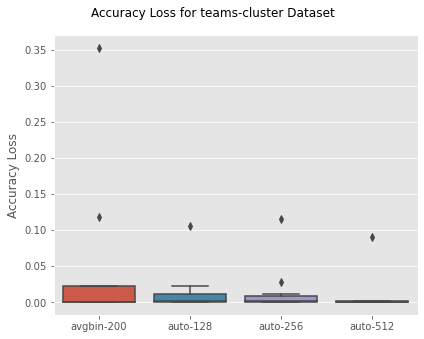

Accuracy scores for teams-cluster Dataset in table \ref{tab:geval-clt-acc-teams-cluster}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.942} &       0.610  &     0.843  &     0.916  &     0.856  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.941} &	\textbf{0.941} &	\textbf{0.941} &     0.940  &	\textbf{0.941} \\
RDF2vec$_{SG}$       &	\textbf{0.942} &	\textbf{0.942} &     0.940  &	\textbf{0.942} &	\textbf{0.942} \\
RDF2vec$_{SG-OA}$    &	\textbf{0.941} &	\textbf{0.941} &	\textbf{0.941} &	\textbf{0.941} &	\textbf{0.941} \\
RESCAL               &	\textbf{0.941} &       0.921  &     0.920  &     0.930  &     0.940  \\
DistMult             &	\textbf{0.942} &       0.830  &	\textbf{0.942} &	\textbf{0.942} &	\textbf{0.942} \\
ComplEx              &	\textbf{0.942} &       0.941  &     0.941  &     0.940  &	\textbf{0.942} \\
TransE-L1            &	\textbf{0.941} &	\textbf{0.

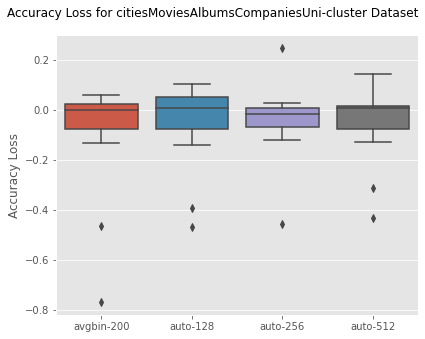

Accuracy scores for citiesMoviesAlbumsCompaniesUni-cluster Dataset in table \ref{tab:geval-clt-acc-citiesmoviesalbumscompaniesuni-cluster}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &         0.433  &	\textbf{0.767} &     0.637  &     0.632  &     0.570  \\
RDF2vec$_{CBOW-OA}$  &         0.548  &	\textbf{0.805} &     0.763  &     0.605  &     0.786  \\
RDF2vec$_{SG}$       &         0.789  &	\textbf{0.808} &     0.794  &     0.804  &     0.807  \\
RDF2vec$_{SG-OA}$    &         0.854  &       0.819  &     0.765  &	\textbf{0.884} &     0.828  \\
RESCAL               &	\textbf{0.894} &       0.871  &     0.874  &     0.872  &     0.883  \\
DistMult             &         0.861  &       0.862  &     0.868  &     0.885  &	\textbf{0.886} \\
ComplEx              &         0.859  &       0.860  &     0.791  &	\textbf{0.864} &     0.849  \\
TransE-L1            &	\textbf{0

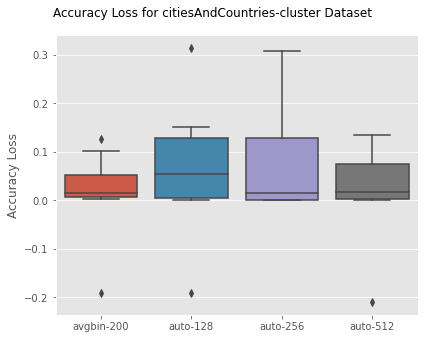

Accuracy scores for citiesAndCountries-cluster Dataset in table \ref{tab:geval-clt-acc-citiesandcountries-cluster}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.785} &       0.705  &     0.539  &     0.543  &     0.741  \\
RDF2vec$_{CBOW-OA}$  &         0.785  &       0.935  &     0.935  &     0.785  &	\textbf{0.950} \\
RDF2vec$_{SG}$       &	\textbf{0.785} &       0.772  &	\textbf{0.785} &	\textbf{0.785} &	\textbf{0.785} \\
RDF2vec$_{SG-OA}$    &	\textbf{0.785} &       0.773  &	\textbf{0.785} &	\textbf{0.785} &	\textbf{0.785} \\
RESCAL               &	\textbf{0.928} &       0.867  &     0.787  &     0.787  &     0.841  \\
DistMult             &	\textbf{0.896} &       0.783  &     0.787  &     0.786  &     0.785  \\
ComplEx              &	\textbf{0.909} &       0.874  &     0.787  &     0.787  &     0.787  \\
TransE-L1            &	\textbf{0.930} &       

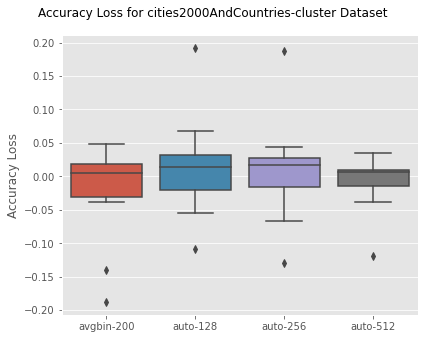

Accuracy scores for cities2000AndCountries-cluster Dataset in table \ref{tab:geval-clt-acc-cities2000andcountries-cluster}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &         0.521  &	\textbf{0.619} &     0.550  &     0.556  &     0.518  \\
RDF2vec$_{CBOW-OA}$  &         0.894  &       0.928  &	\textbf{0.939} &     0.927  &     0.928  \\
RDF2vec$_{SG}$       &         0.751  &	\textbf{0.857} &     0.833  &     0.849  &     0.840  \\
RDF2vec$_{SG-OA}$    &         0.900  &	\textbf{0.922} &     0.728  &     0.731  &     0.916  \\
RESCAL               &	\textbf{0.933} &       0.928  &     0.925  &     0.924  &     0.925  \\
DistMult             &         0.868  &       0.841  &     0.855  &     0.854  &	\textbf{0.878} \\
ComplEx              &	\textbf{0.897} &       0.861  &     0.837  &     0.857  &     0.866  \\
TransE-L1            &	\textbf{0.932} &       0.927 

In [23]:
for gold_standard_file in df_clt_bestscores['gold_standard_file'].unique():
    dataset_lower = str.lower(gold_standard_file).replace("_", "-")
    print("\subsubsection{"+gold_standard_file+" Dataset}")
    print("\label{subsubsec:geval-results-clt-"+dataset_lower+"} \n")

    g = sns.catplot(
        data=df_clt_bestscores[
            (df_clt_bestscores["embedding_variant"]!="original-200")
            & (df_clt_bestscores["gold_standard_file"]==gold_standard_file)
        ], 
        x="embedding_variant", 
        y="acc_loss",
        kind="box",
        aspect=1.2,
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
    )

    g.set_axis_labels("", "Accuracy Loss")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Accuracy Loss for {gold_standard_file} Dataset')

    plt.savefig(f"images/geval-clt-acc-loss-{dataset_lower}.png")

    print("GEval Clustering Accuracy Loss for "+gold_standard_file+" Dataset in Figure \\ref{fig:geval-clt-acc-loss-"+dataset_lower+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \includegraphics[width=0.85\\linewidth]{assets/geval-clt-acc-loss-"+dataset_lower+".png}")
    print("    \caption{GEval Clustering Accuracy Loss for "+gold_standard_file+" Dataset}")
    print("    \label{fig:geval-clt-acc-loss-"+dataset_lower+"}")
    print("\end{figure}\n")

    plt.show()

    print("Accuracy scores for "+gold_standard_file+" Dataset in table \\ref{tab:geval-clt-acc-"+dataset_lower+"}.\n\n")


    print(get_latex_table_clt_acc(gold_standard_file))

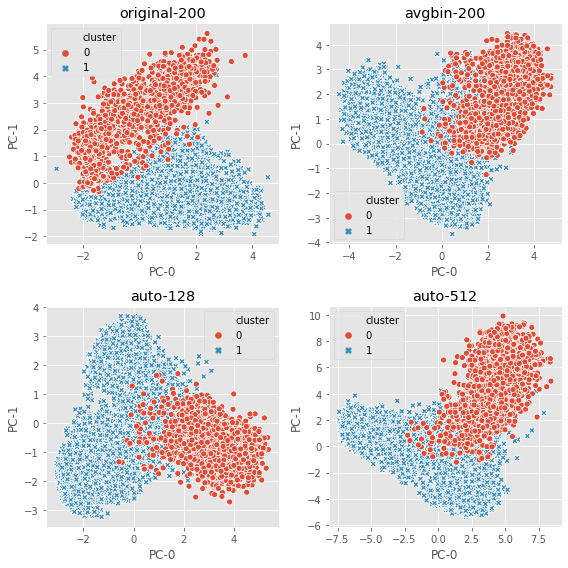

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=0.95\linewidth]{assets/geval-clt-cities-countries-scatter.png}}
    \caption{Class separation of RDF2vec$_{CBOW-OA}$ variants in dataset Cities and Countries, visualized in 2 dimensions using PCA.}
    \label{fig:geval-clt-cities-countries-scatter}
\end{figure}


In [24]:
gold_standard_path = "evaluation_framework/Clustering/data/citiesAndCountries_cluster.tsv"
plot_vector_files = [
    ("original-200", "geval_embeddings/geval-rdf2vec-cbow-oa-200-original.txt", 0, 0),
    ("avgbin-200", "geval_embeddings/geval-rdf2vec-cbow-oa-200-avgbin.txt", 0, 1),
    ("auto-128", "geval_embeddings/geval-rdf2vec-cbow-oa-128-autoencoded.txt", 1, 0),
#     ("auto-256", "geval_embeddings/geval-rdf2vec-cbow-oa-256-autoencoded.txt", 1, 0),
    ("auto-512", "geval_embeddings/geval-rdf2vec-cbow-oa-512-autoencoded.txt", 1, 1),
]

gold_standard_df = pd.read_csv(gold_standard_path, sep='\t')[['DBpedia_URI', 'cluster']]

fig, axs = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(8, 8),
)

for embedding_txt_file_tuple in plot_vector_files:
    title, embedding_txt_file, row, col = embedding_txt_file_tuple
    emb = pd.read_csv(
        embedding_txt_file, sep=' ', header=None
    ).rename(
        columns={0:'DBpedia_URI'}
    )
    emb.pop(emb.columns[-1])
    emb = emb[emb['DBpedia_URI'].isin(gold_standard_df['DBpedia_URI'])]
    emb_df = pd.merge(gold_standard_df, emb, how='inner', on='DBpedia_URI')
    pca = PCA(n_components=2)
    emb_pca = pca.fit_transform(emb_df.iloc[: , 2:])
    emb_df['PC-0'] = emb_pca.T[0]
    emb_df['PC-1'] = emb_pca.T[1]
    
    sns.scatterplot(
        data=emb_df,
        x='PC-0',
        y='PC-1',
        hue='cluster',
        style='cluster',
        ax=axs[row, col],
    ).set(title=title)
plt.tight_layout()

plt.savefig("images/geval-clt-cities-countries-scatter.png")

plt.show()
    
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=0.95\linewidth]{assets/geval-clt-cities-countries-scatter.png}}")
print("    \caption{Class separation of RDF2vec$_{CBOW-OA}$ variants in dataset Cities and Countries, visualized in 2 dimensions using PCA.}")
print("    \label{fig:geval-clt-cities-countries-scatter}")
print("\end{figure}")

## Regression

In [25]:
df_reg = df[
    (df['task_name']=='Regression') 
    & (df['metric']=='root_mean_squared_error')
    & (df['coverage']>=0)
].drop(columns=['test_name'])
df_reg['rank'] = df_reg.groupby(by=['test_name_short', 'gold_standard_file'])['score_value'].rank(
    method='first', 
    ascending=True,
)
df_reg_bestscores = df_reg[df_reg['rank']==1.0].drop(columns=['rank', 'task_name']).sort_values(
    by=['gold_standard_file', 'score_value'], ascending=True
)

df_reg_bestscores['gold_standard_file'].unique()

array(['AAUP', 'Cities', 'Forbes', 'MetacriticAlbums', 'MetacriticMovies'],
      dtype=object)

In [26]:
def get_rmse_gain(gold_standard_file, rmse, embedding_type):
    rmse_original = df_reg_bestscores[
        (df_reg_bestscores["gold_standard_file"]==gold_standard_file)
        & (df_reg_bestscores["embedding_type"]==embedding_type)
        & (df_reg_bestscores["embedding_variant"]=="original-200")
    ]["score_value"].iloc[0]
    
    return (rmse - rmse_original)/rmse_original

def calculate_pvalue_reg(gold_standard_file, rmse, embedding_type, embedding_variant):
    n = dataset_lengths.get(gold_standard_file)
    n_dim = int(embedding_variant.split("-")[-1])
    dfn = n - n_dim
    dfd = n - 200

    rmse_original = df_reg_bestscores[
        (df_reg_bestscores["gold_standard_file"]==gold_standard_file)
        & (df_reg_bestscores["embedding_type"]==embedding_type)
        & (df_reg_bestscores["embedding_variant"]=="original-200")
    ]["score_value"].iloc[0]
    F = (rmse**2) / (rmse_original**2)
    
    if scipy.stats.f.cdf(F, dfn, dfd) >= 0:
    
        return 1 - scipy.stats.f.cdf(F, dfn, dfd)
    
df_reg_bestscores["rmse_gain"] = df_reg_bestscores.apply(
    lambda x: get_rmse_gain(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)
    
df_reg_bestscores["pvalue_worse_than_original"] = df_reg_bestscores.apply(
    lambda x: calculate_pvalue_reg(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
        x.embedding_variant
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)

alpha=0.05
df_reg_bestscores["not_worse_than_original"] = df_reg_bestscores["pvalue_worse_than_original"] >= alpha

df_reg_bestscores[["pvalue_worse_than_original", "rmse_gain"]].describe()

,pvalue_worse_than_original,rmse_gain
count,1.980000e+02,220.000000
mean,2.587949e-01,0.051687
std,3.087546e-01,0.082825
min,9.529932e-12,-0.184429
25%,9.161652e-04,-0.006245
50%,6.747044e-02,0.044520
75%,4.997365e-01,0.111956
max,9.998694e-01,0.319790


In [27]:
caption="Count of GEval regression datasets in which the best regressor of each binary " + \
    "embedding variant did not significantly underperfom the original one in RMSE. " + \
    "The closer to 5, the less is the performance loss. $\\alpha=0.05$."

df_reg_sig_not_worst = pd.pivot_table(
    df_reg_bestscores[df_reg_bestscores["embedding_variant"]!="original-200"],
    values="not_worse_than_original", 
    index=["embedding_type"],
    columns=["embedding_variant"],
    aggfunc=lambda x: sum(x),
).loc[emb_types_ordered,:]

print(caption)
print(r"in table \ref{tab:geval-reg-rmse-significantly-not-worse}.")

print(highlight_best_scores(reorganize_latex_table(df_reg_sig_not_worst.to_latex(
    escape=False,
    index_names=False,
    label="tab:geval-reg-rmse-significantly-not-worse",
    caption=caption,
    columns=[
        "avgbin-200",
        "auto-128",
        "auto-256",
        "auto-512",
    ]
))))

print(df_reg_sig_not_worst.mean())

print(df_reg_sig_not_worst.mean(axis=1))

df_reg_sig_not_worst

Count of GEval regression datasets in which the best regressor of each binary embedding variant did not significantly underperfom the original one in RMSE. The closer to 5, the less is the performance loss. $\alpha=0.05$.
in table \ref{tab:geval-reg-rmse-significantly-not-worse}.
\begin{table}[h!]
\centering
\begin{tabular}{lrrrr}
\toprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{4} &	\textbf{4} &         3  &         1  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{4} &	\textbf{4} &         2  &         1  \\
RDF2vec$_{SG}$       &	\textbf{4} &	\textbf{4} &         1  &         2  \\
RDF2vec$_{SG-OA}$    &           3  &	\textbf{4} &         1  &         2  \\
RESCAL               &	\textbf{4} &         2  &         1  &         1  \\
DistMult             &           1  &	\textbf{4} &         1  &         0  \\
ComplEx              &           2  &	\textbf{3} &         1  &         0  \\
TransE-L1            &	\textbf{5} &	\textbf{5} &       

embedding_variant,auto-128,auto-256,auto-512,avgbin-200
embedding_type,,,,
RDF2vec$_{CBOW}$,4,3,1,4
RDF2vec$_{CBOW-OA}$,4,2,1,4
RDF2vec$_{SG}$,4,1,2,4
RDF2vec$_{SG-OA}$,4,1,2,3
RESCAL,2,1,1,4
DistMult,4,1,0,1
ComplEx,3,1,0,2
TransE-L1,5,3,0,5
TransE-L2,3,0,0,3


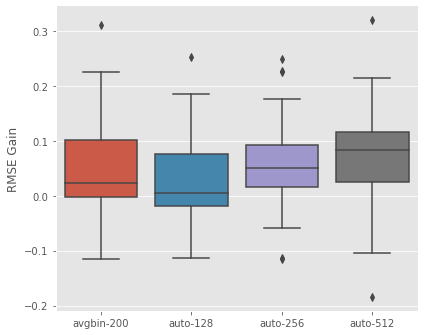

GEval regression RMSE gain by binarization technique in Figure \ref{fig:geval-reg-rmse-gain}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-reg-rmse-gain.png}}
    \caption{GEval Regression RMSE Gain by Binarization Technique}
    \label{fig:geval-reg-rmse-gain}
\end{figure}


In [28]:
g = sns.catplot(
    data=df_reg_bestscores[df_reg_bestscores["embedding_variant"]!="original-200"], 
    x="embedding_variant", 
    y="rmse_gain",
    kind="box",
    aspect=1.2,
    order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "RMSE Gain")
# g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle('GEval Regression NRMSE Gain by Binarization Technique')

plt.savefig("images/geval-reg-rmse-gain.png")

plt.show()
    
print("GEval regression RMSE gain by binarization technique in Figure \\ref{fig:geval-reg-rmse-gain}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-reg-rmse-gain.png}}")
print("    \caption{GEval Regression RMSE Gain by Binarization Technique}")
print("    \label{fig:geval-reg-rmse-gain}")
print("\end{figure}")

In [29]:
def get_latex_table_reg_rmse(gold_standard_file):
    gold_standard_file_lower = str.lower(gold_standard_file).replace("_", "-")
    
    pivot_table = pd.pivot_table(
        df_reg_bestscores[df_reg_bestscores["gold_standard_file"]==gold_standard_file], 
        values="score_value", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="min",
    )
    
    emb_types_ordered_in_pt = [x for x in emb_types_ordered if x in pivot_table.index]
    latex_table = pivot_table.loc[emb_types_ordered_in_pt,:].to_latex(
        float_format="%.2f",
        escape=False,
        index_names=False,
        label=f"tab:geval-reg-rmse-{gold_standard_file_lower}",
        caption=f"RMSE scores for best regressor of each embedding variant in dataset {gold_standard_file}.",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )
    
    return highlight_best_scores(reorganize_latex_table(latex_table), max_value=False)

\subsubsection{AAUP Dataset}
\label{subsubsec:geval-results-reg-aaup} 

GEval Regression RMSE Gain for AAUP Dataset in Figure \ref{fig:geval-reg-rmse-gain-aaup}.

\begin{figure}[h!]
    \centering
    \includegraphics[width=0.85\linewidth]{assets/geval-reg-rmse-gain-aaup.png}
    \caption{GEval Regression RMSE Gain for AAUP Dataset}
    \label{fig:geval-reg-rmse-gain-aaup}
\end{figure}



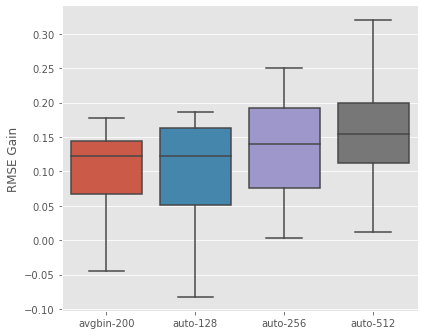

RMSE scores for AAUP Dataset in table \ref{tab:geval-reg-rmse-aaup}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{78.37} &       87.96  &     91.04  &     88.88  &     87.14  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{67.45} &       79.40  &     77.82  &     82.69  &     81.86  \\
RDF2vec$_{SG}$       &	\textbf{65.07} &       72.99  &     76.65  &     74.17  &     72.79  \\
RDF2vec$_{SG-OA}$    &	\textbf{65.15} &       73.55  &     77.27  &     79.98  &     75.51  \\
RESCAL               &	\textbf{69.36} &       78.41  &     75.62  &     79.36  &     75.93  \\
DistMult             &	\textbf{73.82} &       86.43  &     82.81  &     92.26  &     88.89  \\
ComplEx              &	\textbf{76.76} &       88.78  &     85.91  &     88.85  &     91.74  \\
TransE-L1            &         83.19  &       81.55  &	\textbf{79.93} &     85.12  &    109.80  \\
TransE-L2            &

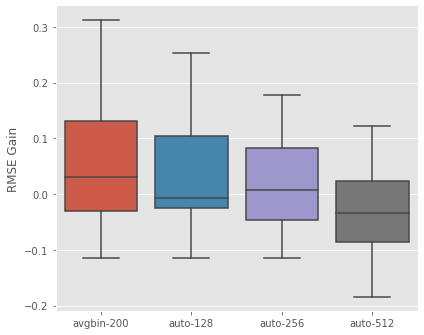

RMSE scores for Cities Dataset in table \ref{tab:geval-reg-rmse-cities}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &         19.64  &       19.15  &     18.12  &	\textbf{17.38} &     19.49  \\
RDF2vec$_{CBOW-OA}$  &         19.96  &       20.58  &	\textbf{19.20} &     19.66  &     19.39  \\
RDF2vec$_{SG}$       &         15.64  &       13.88  &     13.86  &     13.87  &	\textbf{12.76} \\
RDF2vec$_{SG-OA}$    &         13.38  &       15.31  &     13.77  &     14.42  &	\textbf{12.25} \\
RESCAL               &         16.72  &	\textbf{14.81} &     16.56  &     16.17  &     14.98  \\
DistMult             &	\textbf{18.16} &       22.24  &     20.76  &     19.37  &     19.15  \\
ComplEx              &	\textbf{15.85} &       20.80  &     19.85  &     18.66  &     17.80  \\
TransE-L1            &	\textbf{17.12} &       19.17  &     20.03  &     18.61  &     18.08  \\
Tran

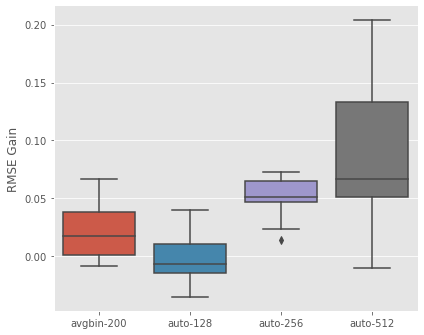

RMSE scores for Forbes Dataset in table \ref{tab:geval-reg-rmse-forbes}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &         39.63  &       39.29  &	\textbf{38.55} &     41.40  &     41.91  \\
RDF2vec$_{CBOW-OA}$  &         37.81  &       37.85  &	\textbf{37.58} &     39.90  &     40.76  \\
RDF2vec$_{SG}$       &	\textbf{36.70} &       37.97  &     37.27  &     39.07  &     38.34  \\
RDF2vec$_{SG-OA}$    &         37.06  &       37.83  &	\textbf{36.61} &     38.89  &     38.41  \\
RESCAL               &         36.84  &       38.37  &     37.05  &     39.26  &	\textbf{36.47} \\
DistMult             &	\textbf{37.31} &       39.81  &     38.29  &     39.89  &     39.81  \\
ComplEx              &	\textbf{36.26} &       37.91  &     37.71  &     38.88  &     39.53  \\
TransE-L1            &         37.93  &       38.03  &	\textbf{37.27} &     38.82  &     45.02  \\
Tr

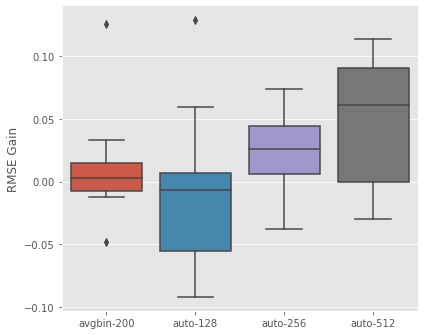

RMSE scores for MetacriticAlbums Dataset in table \ref{tab:geval-reg-rmse-metacriticalbums}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &         15.96  &       15.76  &	\textbf{14.59} &     15.38  &     15.72  \\
RDF2vec$_{CBOW-OA}$  &         15.99  &       15.22  &	\textbf{14.74} &     15.96  &     16.00  \\
RDF2vec$_{SG}$       &         15.63  &       15.69  &	\textbf{14.19} &     15.84  &     15.60  \\
RDF2vec$_{SG-OA}$    &         16.02  &       15.82  &     15.97  &	\textbf{15.42} &     15.54  \\
RESCAL               &	\textbf{14.75} &       14.83  &     15.64  &     15.21  &     15.94  \\
DistMult             &         14.29  &       16.09  &	\textbf{14.20} &     14.94  &     15.70  \\
ComplEx              &	\textbf{14.41} &       14.75  &     16.26  &     15.05  &     16.04  \\
TransE-L1            &         14.83  &       14.79  &	\textbf{14.41} &     1

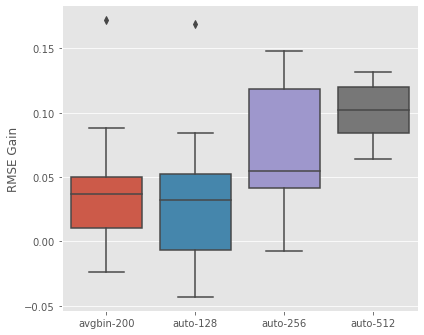

RMSE scores for MetacriticMovies Dataset in table \ref{tab:geval-reg-rmse-metacriticmovies}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &         24.96  &       24.37  &	\textbf{23.88} &     24.78  &     26.56  \\
RDF2vec$_{CBOW-OA}$  &         23.57  &       23.26  &	\textbf{23.12} &     23.95  &     25.55  \\
RDF2vec$_{SG}$       &	\textbf{20.46} &       21.22  &     21.01  &     21.80  &     23.12  \\
RDF2vec$_{SG-OA}$    &	\textbf{20.57} &       21.60  &     21.33  &     23.63  &     22.85  \\
RESCAL               &	\textbf{21.67} &       22.23  &     23.51  &     22.86  &     23.72  \\
DistMult             &	\textbf{21.40} &       25.08  &     22.09  &     24.08  &     24.22  \\
ComplEx              &	\textbf{21.16} &       23.02  &     21.86  &     23.98  &     23.33  \\
TransE-L1            &         22.99  &       23.16  &	\textbf{22.92} &     24.01  &     

In [30]:
for gold_standard_file in df_reg_bestscores['gold_standard_file'].unique():
    dataset_lower = str.lower(gold_standard_file).replace("_", "-")
    print("\subsubsection{"+gold_standard_file+" Dataset}")
    print("\label{subsubsec:geval-results-reg-"+dataset_lower+"} \n")

    g = sns.catplot(
        data=df_reg_bestscores[
            (df_reg_bestscores["embedding_variant"]!="original-200")
            & (df_reg_bestscores["gold_standard_file"]==gold_standard_file)
        ], 
        x="embedding_variant", 
        y="rmse_gain",
        kind="box",
        aspect=1.2,
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
    )

    g.set_axis_labels("", "RMSE Gain")
#     g.fig.subplots_adjust(top=0.9)
#     g.fig.suptitle(f'NRMSE Gain for {gold_standard_file} Dataset')

    plt.savefig(f"images/geval-reg-rmse-gain-{dataset_lower}.png")

    print("GEval Regression RMSE Gain for "+gold_standard_file+" Dataset in Figure \\ref{fig:geval-reg-rmse-gain-"+dataset_lower+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \includegraphics[width=0.85\\linewidth]{assets/geval-reg-rmse-gain-"+dataset_lower+".png}")
    print("    \caption{GEval Regression RMSE Gain for "+gold_standard_file+" Dataset}")
    print("    \label{fig:geval-reg-rmse-gain-"+dataset_lower+"}")
    print("\end{figure}\n")

    plt.show()

    print("RMSE scores for "+gold_standard_file+" Dataset in table \\ref{tab:geval-reg-rmse-"+dataset_lower+"}.\n\n")


    print(get_latex_table_reg_rmse(gold_standard_file))

## Document Similarity

In [31]:
df_docsim = df[
    (df['task_name']=='DocumentSimilarity') 
    & (df['metric']=='harmonic_mean')
    & (df['coverage']>=0)
].drop(columns=['test_name'])
df_docsim['rank'] = df_docsim.groupby(by=['test_name_short', 'gold_standard_file'])['score_value'].rank(
    method='first', 
    ascending=False,
)
df_docsim_bestscores = df_docsim[df_docsim['rank']==1.0].drop(columns=['rank', 'task_name']).sort_values(
    by=['gold_standard_file', 'score_value'], ascending=False
)

df_docsim_bestscores['gold_standard_file'].unique()

array(['LP50'], dtype=object)

In [32]:
df_docsim_bestscores

,gold_standard_file,coverage,model,model_configuration,metric,score_value,test_name_short,embedding_type,embedding_variant
296,LP50,0.945141,with_weights,-,harmonic_mean,0.524676,non-rdf2vec-TransR-512-autoencoded,TransR,auto-512
116,LP50,0.945141,with_weights,-,harmonic_mean,0.510978,non-rdf2vec-TransR-200-avgbin,TransR,avgbin-200
56,LP50,0.945141,with_weights,-,harmonic_mean,0.505859,non-rdf2vec-TransR-200-original,TransR,original-200
9464,LP50,0.940439,with_weights,-,harmonic_mean,0.498953,rdf2vec-sg-128-autoencoded,RDF2vec$_{SG}$,auto-128
92,LP50,0.945141,with_weights,-,harmonic_mean,0.484123,non-rdf2vec-RESCAL-200-avgbin,RESCAL,avgbin-200
212,LP50,0.945141,with_weights,-,harmonic_mean,0.469372,non-rdf2vec-RESCAL-256-autoencoded,RESCAL,auto-256
278,LP50,0.945141,with_weights,-,harmonic_mean,0.464166,non-rdf2vec-RotatE-512-autoencoded,RotatE,auto-512
134,LP50,0.940439,with_weights,-,harmonic_mean,0.462405,rdf2vec-sg-oa-128-autoencoded,RDF2vec$_{SG-OA}$,auto-128
38,LP50,0.945141,with_weights,-,harmonic_mean,0.457817,non-rdf2vec-RotatE-200-original,RotatE,original-200
236,LP50,0.945141,with_weights,-,harmonic_mean,0.453453,non-rdf2vec-TransR-256-autoencoded,TransR,auto-256


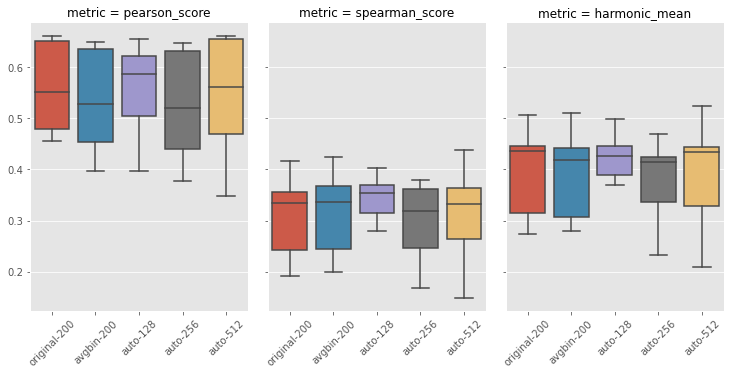

GEval document similarity Pearson's and Speraman's correlations and harmonic mean between them by binarization technique in Figure \ref{fig:geval-docsim-hm}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/geval-docsim-hm.png}}
    \caption{GEval Document Similarity Pearson's and Speraman's correlations and harmonic mean between them by Binarization Technique}
    \label{fig:geval-docsim-hm}
\end{figure}


In [33]:
g = sns.catplot(
    data=df[
        (df['task_name']=='DocumentSimilarity') 
        & (df['model']=='with_weights')
        & (df['coverage']>=0)
    ], 
    x="embedding_variant", 
    y="score_value",
    kind="box",
    aspect=0.7,
    col="metric",
    order=["original-200", "avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "")
# g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle("Document Similarity Correlation scores by Binarization Technique")
g.set_xticklabels(rotation=45)

plt.savefig("images/geval-docsim-hm.png")

plt.show()

print("GEval document similarity Pearson's and Speraman's correlations and harmonic mean between them by binarization technique in Figure \\ref{fig:geval-docsim-hm}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=1.45\linewidth]{assets/geval-docsim-hm.png}}")
print("    \caption{GEval Document Similarity Pearson's and Speraman's correlations and harmonic mean between them by Binarization Technique}")
print("    \label{fig:geval-docsim-hm}")
print("\end{figure}")

In [34]:
def get_latex_table_docsim_harm_mean(gold_standard_file):
    gold_standard_file_lower = str.lower(gold_standard_file).replace("_", "-")
    
    latex_table = pd.pivot_table(
        df_docsim_bestscores[df_docsim_bestscores["gold_standard_file"]==gold_standard_file], 
        values="score_value", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).loc[emb_types_ordered,:].to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:geval-docsim-hm-{gold_standard_file_lower}",
        caption=f"Harmonic Mean scores for best model of each embedding variant in dataset {gold_standard_file}",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )
    
    return highlight_best_scores(reorganize_latex_table(latex_table))

In [35]:
gold_standard_file = "LP50"

dataset_lower = str.lower(gold_standard_file).replace("_", "-")

print("Harmonic mean between Pearson's and Speraman's correlations for "+gold_standard_file+" Dataset in table \\ref{tab:geval-docsim-hm-"+dataset_lower+"}.\n\n")


print(get_latex_table_docsim_harm_mean(gold_standard_file))

Harmonic mean between Pearson's and Speraman's correlations for LP50 Dataset in table \ref{tab:geval-docsim-hm-lp50}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &         0.352  &       0.316  &	\textbf{0.374} &     0.373  &     0.349  \\
RDF2vec$_{CBOW-OA}$  &         0.273  &       0.280  &	\textbf{0.370} &     0.234  &     0.209  \\
RDF2vec$_{SG}$       &         0.278  &       0.281  &	\textbf{0.499} &     0.301  &     0.286  \\
RDF2vec$_{SG-OA}$    &         0.275  &       0.297  &	\textbf{0.462} &     0.246  &     0.308  \\
RESCAL               &         0.408  &	\textbf{0.484} &     0.427  &     0.469  &     0.427  \\
DistMult             &	\textbf{0.445} &       0.380  &     0.384  &     0.378  &     0.435  \\
ComplEx              &	\textbf{0.442} &	\textbf{0.442} &     0.396  &     0.414  &	\textbf{0.442} \\
TransE-L1            &         0.435  &       0.

## Entity Relatedness

In [36]:
df_entrel = df[
    (df['task_name']=='EntityRelatedness') 
    & (df['coverage']>=0)
].drop(columns=['test_name'])
df_entrel['rank'] = df_entrel.groupby(by=['test_name_short', 'gold_standard_file'])['score_value'].rank(
    method='first', 
    ascending=False,
)
df_entrel_bestscores = df_entrel[df_entrel['rank']==1.0].drop(columns=['rank', 'task_name']).sort_values(
    by=['gold_standard_file', 'score_value'], ascending=False
)

df_entrel_bestscores['gold_standard_file'].unique()

array(['KORE'], dtype=object)

In [37]:
df_entrel_bestscores

,gold_standard_file,coverage,model,model_configuration,metric,score_value,test_name_short,embedding_type,embedding_variant
9480,KORE,1.0,-,-,kendalltau_correlation,0.504261,rdf2vec-sg-200-original,RDF2vec$_{SG}$,original-200
9484,KORE,1.0,-,-,kendalltau_correlation,0.478195,rdf2vec-sg-512-autoencoded,RDF2vec$_{SG}$,auto-512
9481,KORE,1.0,-,-,kendalltau_correlation,0.468170,rdf2vec-sg-200-avgbin,RDF2vec$_{SG}$,avgbin-200
9483,KORE,1.0,-,-,kendalltau_correlation,0.458647,rdf2vec-sg-256-autoencoded,RDF2vec$_{SG}$,auto-256
302,KORE,1.0,-,-,kendalltau_correlation,0.419048,rdf2vec-sg-oa-200-original,RDF2vec$_{SG-OA}$,original-200
9482,KORE,1.0,-,-,kendalltau_correlation,0.417043,rdf2vec-sg-128-autoencoded,RDF2vec$_{SG}$,auto-128
332,KORE,1.0,-,-,kendalltau_correlation,0.383960,rdf2vec-sg-oa-256-autoencoded,RDF2vec$_{SG-OA}$,auto-256
342,KORE,1.0,-,-,kendalltau_correlation,0.372932,rdf2vec-sg-oa-512-autoencoded,RDF2vec$_{SG-OA}$,auto-512
312,KORE,1.0,-,-,kendalltau_correlation,0.347870,rdf2vec-sg-oa-200-avgbin,RDF2vec$_{SG-OA}$,avgbin-200
322,KORE,1.0,-,-,kendalltau_correlation,0.339348,rdf2vec-sg-oa-128-autoencoded,RDF2vec$_{SG-OA}$,auto-128


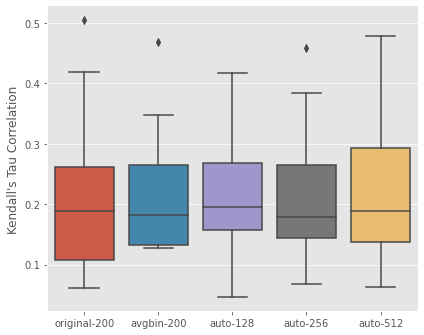

GEval entity relatedness Kendall's tau correlation by binarization technique in Figure \ref{fig:geval-entrel-tau}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.05\linewidth]{assets/geval-entrel-tau.png}}
    \caption{GEval Entity Relatedness Kendall's Tau Correlation by Binarization Technique}
    \label{fig:geval-entrel-tau}
\end{figure}


In [38]:
g = sns.catplot(
    data=df_entrel_bestscores, 
    x="embedding_variant", 
    y="score_value",
    kind="box",
    aspect=1.2,
    order=["original-200", "avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "Kendall's Tau Correlation")
# g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle("Kendall's Tau Correlation by Binarization Technique")

plt.savefig("images/geval-entrel-tau.png")

plt.show()
    
print("GEval entity relatedness Kendall's tau correlation by binarization technique in Figure \\ref{fig:geval-entrel-tau}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=1.05\linewidth]{assets/geval-entrel-tau.png}}")
print("    \caption{GEval Entity Relatedness Kendall's Tau Correlation by Binarization Technique}")
print("    \label{fig:geval-entrel-tau}")
print("\end{figure}")

In [39]:
def get_latex_table_entrel_tau(gold_standard_file):
    gold_standard_file_lower = str.lower(gold_standard_file).replace("_", "-")
    
    latex_table = pd.pivot_table(
        df_entrel_bestscores[df_entrel_bestscores["gold_standard_file"]==gold_standard_file], 
        values="score_value", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).loc[emb_types_ordered,:].to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:geval-entrel-tau-{gold_standard_file_lower}",
        caption=f"Kendall's Tau correlation scores for each embedding variant in dataset {gold_standard_file}",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )
    
    return highlight_best_scores(reorganize_latex_table(latex_table))

In [40]:
gold_standard_file = "KORE"

dataset_lower = str.lower(gold_standard_file).replace("_", "-")

print("Kendall's Tau correlation for "+gold_standard_file+" Dataset in table \\ref{tab:geval-entrel-tau-"+dataset_lower+"}.\n\n")


print(get_latex_table_entrel_tau(gold_standard_file))

Kendall's Tau correlation for KORE Dataset in table \ref{tab:geval-entrel-tau-kore}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &         0.290  &       0.311  &     0.287  &	\textbf{0.315} &	\textbf{0.315} \\
RDF2vec$_{CBOW-OA}$  &         0.121  &       0.128  &	\textbf{0.155} &     0.152  &     0.095  \\
RDF2vec$_{SG}$       &	\textbf{0.504} &       0.468  &     0.417  &     0.459  &     0.478  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.419} &       0.348  &     0.339  &     0.384  &     0.373  \\
RESCAL               &	\textbf{0.188} &       0.183  &     0.123  &     0.128  &     0.123  \\
DistMult             &         0.130  &       0.138  &     0.164  &	\textbf{0.178} &     0.153  \\
ComplEx              &	\textbf{0.234} &       0.218  &     0.208  &     0.208  &     0.223  \\
TransE-L1            &         0.095  &       0.128  &     0.160  &     0.137  &	\textbf{

## Semantic Analogies

In [41]:
df_semana = df[
    (df['task_name']=='SemanticAnalogies') 
    & (df['coverage']>=0)
].drop(columns=['test_name'])
df_semana['rank'] = df_semana.groupby(by=['test_name_short', 'gold_standard_file'])['score_value'].rank(
    method='first', 
    ascending=False,
)
df_semana_bestscores = df_semana[df_semana['rank']==1.0].drop(columns=['rank', 'task_name']).sort_values(
    by=['gold_standard_file', 'score_value'], ascending=False
)

df_semana_bestscores['gold_standard_file'].unique()

array(['currency-entities', 'city-state-entities',
       'capital-country-entities', 'all-capital-country-entities'],
      dtype=object)

In [42]:
def get_acc_loss(gold_standard_file, score_value, embedding_type):
    p = df_semana_bestscores[
        (df_semana_bestscores["gold_standard_file"]==gold_standard_file)
        & (df_semana_bestscores["embedding_type"]==embedding_type)
        & (df_semana_bestscores["embedding_variant"]=="original-200")
    ]["score_value"].iloc[0]

    return p - score_value


def calculate_pvalue_semana(gold_standard_file, score_value, embedding_type):
    n = dataset_lengths.get(gold_standard_file)
    successes = round(n*score_value)

    p = df_semana_bestscores[
        (df_semana_bestscores["gold_standard_file"]==gold_standard_file)
        & (df_semana_bestscores["embedding_type"]==embedding_type)
        & (df_semana_bestscores["embedding_variant"]=="original-200")
    ]["score_value"].iloc[0]

    return binomtest(successes, n, p, alternative='less').pvalue
    
df_semana_bestscores["acc_loss"] = df_semana_bestscores.apply(
    lambda x: get_acc_loss(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)
    
df_semana_bestscores["pvalue_worse_than_original"] = df_semana_bestscores.apply(
    lambda x: calculate_pvalue_semana(
        x.gold_standard_file, 
        x.score_value, 
        x.embedding_type,
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)

alpha=0.05
df_semana_bestscores["not_worse_than_original"] = df_semana_bestscores["pvalue_worse_than_original"] >= alpha

df_semana_bestscores[["pvalue_worse_than_original", "acc_loss"]].describe()

,pvalue_worse_than_original,acc_loss
count,1.760000e+02,176.000000
mean,5.664130e-02,0.197125
std,1.708541e-01,0.163918
min,0.000000e+00,-0.032178
25%,4.847341e-15,0.079954
50%,1.497698e-05,0.152805
75%,1.606940e-02,0.277017
max,9.306922e-01,0.788538


In [43]:
caption = "Count of GEval Semantic Analogies datasets in which the best model " + \
    "of each binary embedding variant did not significantly underperfom the original one in precision@10. " + \
    "The closer to 4, the less is the performance loss. $\\alpha=0.05$."

df_semana_sig_not_worst = pd.pivot_table(
    df_semana_bestscores[df_semana_bestscores["embedding_variant"]!="original-200"],
    values="not_worse_than_original", 
    index=["embedding_type"],
    columns=["embedding_variant"],
    aggfunc=lambda x: sum(x),
).loc[emb_types_ordered,:]

print(caption)
print(r"in table \ref{tab:geval-semana-p-at-10-significantly-not-worse}.")

print(highlight_best_scores(reorganize_latex_table(df_semana_sig_not_worst.to_latex(
    escape=False,
    index_names=False,
    label="tab:geval-semana-p-at-10-significantly-not-worse",
    caption=caption,
    columns=[
        "avgbin-200",
        "auto-128",
        "auto-256",
        "auto-512",
    ]
))))

print(df_semana_sig_not_worst.mean())

print(df_semana_sig_not_worst.mean(axis=1))

df_semana_sig_not_worst

Count of GEval Semantic Analogies datasets in which the best model of each binary embedding variant did not significantly underperfom the original one in precision@10. The closer to 4, the less is the performance loss. $\alpha=0.05$.
in table \ref{tab:geval-semana-p-at-10-significantly-not-worse}.
\begin{table}[h!]
\centering
\begin{tabular}{lrrrr}
\toprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
	\textbf{RDF2vec$_{CBOW}$} &	\textbf{0} &	\textbf{0} &	\textbf{0} &	\textbf{0} \\
	\textbf{RDF2vec$_{CBOW-OA}$} &	\textbf{0} &	\textbf{0} &	\textbf{0} &	\textbf{0} \\
RDF2vec$_{SG}$       &	\textbf{1} &         0  &         0  &	\textbf{1} \\
RDF2vec$_{SG-OA}$    &	\textbf{1} &         0  &         0  &	\textbf{1} \\
RESCAL               &           3  &         2  &         2  &	\textbf{4} \\
DistMult             &           1  &         1  &         1  &	\textbf{2} \\
ComplEx              &           0  &         0  &	\textbf{1} &	\textbf{1} \\
	\textbf{TransE-L1} &	

embedding_variant,auto-128,auto-256,auto-512,avgbin-200
embedding_type,,,,
RDF2vec$_{CBOW}$,0,0,0,0
RDF2vec$_{CBOW-OA}$,0,0,0,0
RDF2vec$_{SG}$,0,0,1,1
RDF2vec$_{SG-OA}$,0,0,1,1
RESCAL,2,2,4,3
DistMult,1,1,2,1
ComplEx,0,1,1,0
TransE-L1,0,0,0,0
TransE-L2,0,0,0,1


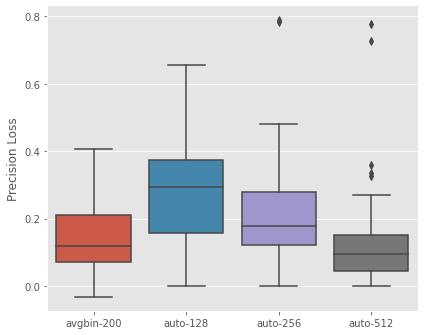

GEval semantic analogies precision loss by binarization technique in Figure \ref{fig:geval-semana-p-loss}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-semana-p-loss.png}}
    \caption{GEval Semantic Analogies Precision Loss by Binarization Technique}
    \label{fig:geval-semana-p-loss}
\end{figure}


In [44]:
g = sns.catplot(
    data=df_semana_bestscores[df_semana_bestscores["embedding_variant"]!="original-200"], 
    x="embedding_variant", 
    y="acc_loss",
    kind="box",
    aspect=1.2,
    order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "Precision Loss")
# g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle('GEval Semantic Analogies Precision Loss by Binarization Technique')

plt.savefig("images/geval-semana-p-loss.png")

plt.show()
    
print("GEval semantic analogies precision loss by binarization technique in Figure \\ref{fig:geval-semana-p-loss}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=0.85\linewidth]{assets/geval-semana-p-loss.png}}")
print("    \caption{GEval Semantic Analogies Precision Loss by Binarization Technique}")
print("    \label{fig:geval-semana-p-loss}")
print("\end{figure}")

In [45]:
def get_latex_table_semana(gold_standard_file):
    gold_standard_file_lower = str.lower(gold_standard_file).replace("_", "-")
    
    pivot_table = pd.pivot_table(
        df_semana_bestscores[df_semana_bestscores["gold_standard_file"]==gold_standard_file], 
        values="score_value", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    )
    
    emb_types_ordered_in_pt = [x for x in emb_types_ordered if x in pivot_table.index]
    latex_table = pivot_table.loc[emb_types_ordered_in_pt,:].to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:geval-semana-p-at-10-{gold_standard_file_lower}",
        caption=f"Precision at 10 scores for best model of each embedding variant in dataset {gold_standard_file}",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )
    
    return highlight_best_scores(reorganize_latex_table(latex_table))

\subsubsection{currency-entities Dataset}
\label{subsubsec:geval-results-semana-currency-entities} 

GEval Semantic Analogies Precision Loss for currency-entities Dataset in Figure \ref{fig:geval-semana-p-loss-currency-entities}.

\begin{figure}[h!]
    \centering
    \includegraphics[width=0.85\linewidth]{assets/geval-semana-p-loss-currency-entities.png}
    \caption{GEval Semantic Analogies Precision Loss for currency-entities Dataset}
    \label{fig:geval-semana-p-loss-currency-entities}
\end{figure}



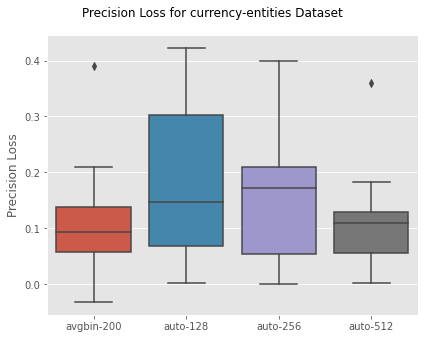

Precision scores for currency-entities Dataset in table \ref{tab:geval-semana-p-at-10-currency-entities}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.488} &       0.338  &     0.215  &     0.272  &     0.304  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.582} &       0.374  &     0.185  &     0.184  &     0.222  \\
RDF2vec$_{SG}$       &	\textbf{0.675} &       0.550  &     0.558  &     0.472  &     0.562  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.637} &       0.544  &     0.491  &     0.435  &     0.553  \\
RESCAL               &         0.079  &	\textbf{0.111} &     0.043  &     0.042  &     0.031  \\
DistMult             &	\textbf{0.045} &       0.005  &     0.004  &     0.009  &     0.019  \\
ComplEx              &	\textbf{0.101} &       0.017  &     0.006  &     0.030  &     0.040  \\
TransE-L1            &	\textbf{0.504} &       0.114  &     0.082  &     0.134  &  

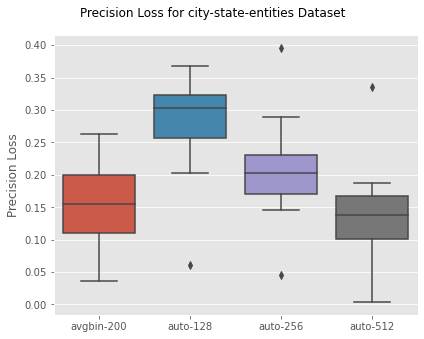

Precision scores for city-state-entities Dataset in table \ref{tab:geval-semana-p-at-10-city-state-entities}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.596} &       0.485  &     0.255  &     0.381  &     0.409  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.568} &       0.369  &     0.263  &     0.173  &     0.233  \\
RDF2vec$_{SG}$       &	\textbf{0.701} &       0.547  &     0.498  &     0.455  &     0.518  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.738} &       0.603  &     0.474  &     0.449  &     0.587  \\
RESCAL               &	\textbf{0.314} &       0.277  &     0.254  &     0.269  &     0.310  \\
DistMult             &	\textbf{0.541} &       0.278  &     0.234  &     0.327  &     0.403  \\
ComplEx              &	\textbf{0.578} &       0.315  &     0.228  &     0.376  &     0.430  \\
TransE-L1            &	\textbf{0.610} &       0.432  &     0.306  &     0.454  &

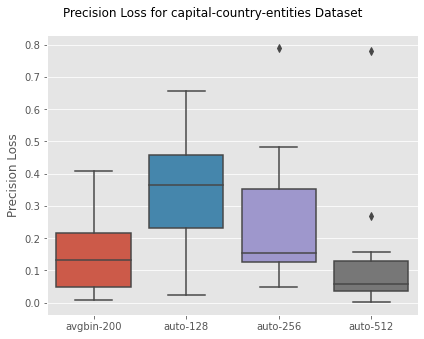

Precision scores for capital-country-entities Dataset in table \ref{tab:geval-semana-p-at-10-capital-country-entities}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.909} &       0.690  &     0.253  &     0.427  &     0.640  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.907} &       0.500  &     0.403  &     0.119  &     0.128  \\
RDF2vec$_{SG}$       &	\textbf{1.000} &       0.982  &     0.976  &     0.858  &     0.947  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.986} &       0.854  &     0.883  &     0.593  &     0.830  \\
RESCAL               &	\textbf{0.872} &       0.864  &     0.601  &     0.761  &     0.870  \\
DistMult             &	\textbf{0.988} &       0.775  &     0.617  &     0.848  &     0.953  \\
ComplEx              &	\textbf{0.994} &       0.725  &     0.561  &     0.840  &     0.923  \\
TransE-L1            &	\textbf{0.994} &       0.943  &     0.769  &   

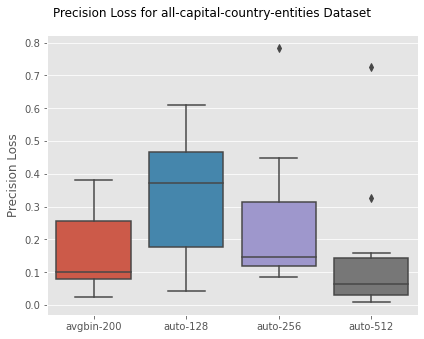

Precision scores for all-capital-country-entities Dataset in table \ref{tab:geval-semana-p-at-10-all-capital-country-entities}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.735} &       0.407  &     0.126  &     0.288  &     0.409  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.852} &       0.471  &     0.242  &     0.070  &     0.126  \\
RDF2vec$_{SG}$       &	\textbf{0.952} &       0.929  &     0.910  &     0.808  &     0.889  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.944} &       0.844  &     0.836  &     0.670  &     0.816  \\
RESCAL               &	\textbf{0.688} &       0.588  &     0.494  &     0.561  &     0.670  \\
DistMult             &	\textbf{0.960} &       0.740  &     0.586  &     0.851  &     0.931  \\
ComplEx              &	\textbf{0.968} &       0.782  &     0.620  &     0.871  &     0.937  \\
TransE-L1            &	\textbf{0.961} &       0.863  &     0.5

In [46]:
for gold_standard_file in df_semana_bestscores['gold_standard_file'].unique():
    dataset_lower = str.lower(gold_standard_file).replace("_", "-")
    print("\subsubsection{"+gold_standard_file+" Dataset}")
    print("\label{subsubsec:geval-results-semana-"+dataset_lower+"} \n")

    g = sns.catplot(
        data=df_semana_bestscores[
            (df_semana_bestscores["embedding_variant"]!="original-200")
            & (df_semana_bestscores["gold_standard_file"]==gold_standard_file)
        ], 
        x="embedding_variant", 
        y="acc_loss",
        kind="box",
        aspect=1.2,
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
    )

    g.set_axis_labels("", "Precision Loss")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Precision Loss for {gold_standard_file} Dataset')

    plt.savefig(f"images/geval-semana-p-loss-{dataset_lower}.png")

    print("GEval Semantic Analogies Precision Loss for "+gold_standard_file+" Dataset in Figure \\ref{fig:geval-semana-p-loss-"+dataset_lower+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \includegraphics[width=0.85\\linewidth]{assets/geval-semana-p-loss-"+dataset_lower+".png}")
    print("    \caption{GEval Semantic Analogies Precision Loss for "+gold_standard_file+" Dataset}")
    print("    \label{fig:geval-semana-p-loss-"+dataset_lower+"}")
    print("\end{figure}\n")

    plt.show()

    print("Precision scores for "+gold_standard_file+" Dataset in table \\ref{tab:geval-semana-p-at-10-"+dataset_lower+"}.\n\n")


    print(get_latex_table_semana(gold_standard_file))

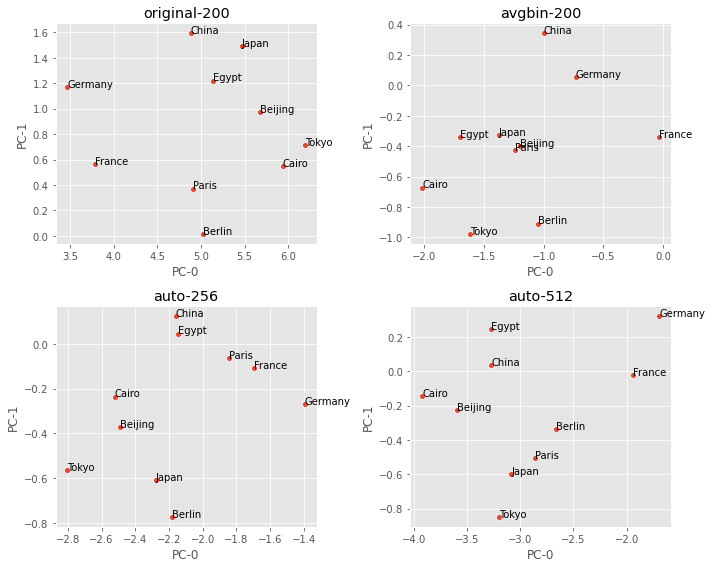

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=0.95\linewidth]{assets/geval-semana-translations-scatter.png}}
    \caption{TransE-L2 embedding variants of selected capitals and countries from Semantic Analogies dataset Cities and Countries, visualized in 2 dimensions using PCA.}
    \label{fig:geval-semana-translations-scatter}
\end{figure}


In [47]:
cities_countries = [
    "http://dbpedia.org/resource/Berlin",
    "http://dbpedia.org/resource/Germany",
    "http://dbpedia.org/resource/Paris",
    "http://dbpedia.org/resource/France",
    "http://dbpedia.org/resource/Tokyo",
    "http://dbpedia.org/resource/Japan",
    "http://dbpedia.org/resource/Cairo",
    "http://dbpedia.org/resource/Egypt",
    "http://dbpedia.org/resource/Beijing",
    "http://dbpedia.org/resource/China",
]

plot_vector_files = [
    ("original-200", "geval_embeddings/geval-non-rdf2vec-TransE-L2-200-original.txt", 0, 0),
    ("avgbin-200", "geval_embeddings/geval-non-rdf2vec-TransE-L2-200-avgbin.txt", 0, 1),
#     ("auto-128", "geval_embeddings/geval-non-rdf2vec-TransE-L2-128-autoencoded.txt", 1, 0),
    ("auto-256", "geval_embeddings/geval-non-rdf2vec-TransE-L2-256-autoencoded.txt", 1, 0),
    ("auto-512", "geval_embeddings/geval-non-rdf2vec-TransE-L2-512-autoencoded.txt", 1, 1),
]

fig, axs = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(10, 8),
)

for embedding_txt_file_tuple in plot_vector_files:
    title, embedding_txt_file, row, col = embedding_txt_file_tuple
    emb = pd.read_csv(
        embedding_txt_file, sep=' ', header=None
    ).rename(
        columns={0:'DBpedia_URI'}
    )
    emb.pop(emb.columns[-1])
    pca = PCA(n_components=2)
    emb_pca = pca.fit_transform(emb.iloc[: , 2:])
    emb['PC-0'] = emb_pca.T[0]
    emb['PC-1'] = emb_pca.T[1]
    
    emb_plot = emb[emb['DBpedia_URI'].isin(cities_countries)]
    sns.scatterplot(
        data=emb_plot,
        x='PC-0',
        y='PC-1',
        ax=axs[row, col],
        cmap="grays",
    ).set(title=title)
    
    for i, point in emb_plot.iterrows():
        axs[row, col].text(point['PC-0'], point['PC-1'], str(point['DBpedia_URI']).split("/")[-1])
plt.tight_layout()

plt.savefig("images/geval-semana-translations-scatter.png")

plt.show()
    
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=0.95\linewidth]{assets/geval-semana-translations-scatter.png}}")
print("    \caption{TransE-L2 embedding variants of selected capitals and countries from Semantic Analogies dataset Cities and Countries, visualized in 2 dimensions using PCA.}")
print("    \label{fig:geval-semana-translations-scatter}")
print("\end{figure}")